In [1]:
import csv
import psycopg2
import sqlalchemy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from scipy.stats import t
from datetime import datetime

# Introduction
The dataset on which the student worked contains information on individuals and households who are eligible for Medicaid, Cash Assistance, and/or Supplemental Nutrition Assistance Program. The student's project aims to answer the question, "How does the distribution of Medicaid (MA) enrollees vary across different boroughs in NYC, and are there any notable disparities in enrollment rates?".

# Data Summary
The data was acquired from Data.gov, a repository of various public datasets provided by the United States government. This data was then put into a csv file stored on github.

In [2]:
drs_data = pd.read_csv('https://raw.githubusercontent.com/ktxdev/AIM-5001/main/Project%201/2.%20Data/DRS.csv')

### Cases

In [3]:
print("Number of cases: ", len(drs_data))
print("Number of attributes per case: ", len(drs_data))

Number of cases:  354
Number of attributes per case:  354


### Data types of attributes

In [4]:
drs_data.dtypes

Data published in District Resource Statement                             object
Data as of                                                                object
Borough                                                                   object
Community District                                                        object
DRS Medicaid (MA) Only Enrollees                                           int64
DRS Total Medicaid (MA) Enrollees                                          int64
DRS Cash Assistance (CA) Recipients                                        int64
DRS Cash Assistance (CA) Cases                                             int64
DRS Total Supplemental Nutrition Assistance Program (SNAP)  Recipients     int64
DRS Total Supplemental Nutrition Assistance Program (SNAP)  Households     int64
dtype: object

### Descriptive statistics 

In [6]:
drs_data.describe(include = "all")

,Data published in District Resource Statement,Data as of,Borough,Community District,DRS Medicaid (MA) Only Enrollees,DRS Total Medicaid (MA) Enrollees,DRS Cash Assistance (CA) Recipients,DRS Cash Assistance (CA) Cases,DRS Total Supplemental Nutrition Assistance Program (SNAP) Recipients,DRS Total Supplemental Nutrition Assistance Program (SNAP) Households
count,354,354,354,354,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000
unique,6,6,5,59,NaN,NaN,NaN,NaN,NaN,NaN
top,FY 2018,10/31/2017,BROOKLYN,B01,NaN,NaN,NaN,NaN,NaN,NaN
freq,59,59,108,6,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,14684.333333,27183.819209,6361.305085,3460.081921,27602.709040,16097.485876
std,NaN,NaN,NaN,NaN,8400.397596,13420.794009,4653.442781,2348.526239,15391.991415,8097.041116
min,NaN,NaN,NaN,NaN,1410.000000,2512.000000,315.000000,263.000000,1965.000000,1511.000000
25%,NaN,NaN,NaN,NaN,9055.000000,17370.250000,2942.750000,1751.000000,16542.750000,10167.000000
50%,NaN,NaN,NaN,NaN,13409.500000,26647.500000,4647.500000,2688.000000,24706.000000,14928.000000
75%,NaN,NaN,NaN,NaN,18482.500000,36842.250000,9683.250000,5205.750000,39043.250000,21409.000000


# Data Management using PostgreSQL

## ER Diagram for District Resource Statement database
![ER Diagram](https://raw.githubusercontent.com/ktxdev/AIM-5001/main/Project%201/1.%20Literature/ER%20Diagram.png)

## SQL Statements to create database and tables
### Statement to create database
```sql
CREATE DATABASE drs;
```
### Statements to create tables
```sql
CREATE TABLE borough (
    id INT GENERATED ALWAYS AS IDENTITY,
    name VARCHAR (50) UNIQUE NOT NULL,
    PRIMARY KEY(id)
);
    
CREATE TABLE community_district (
    id INT GENERATED ALWAYS AS IDENTITY,
    borough_id INT,
    name VARCHAR(20) NOT NULL,

    PRIMARY KEY(id),
    CONSTRAINT fk_borough FOREIGN KEY(borough_id) REFERENCES borough(id) ON DELETE CASCADE
);
    
CREATE TABLE drs_case (
    id INT GENERATED ALWAYS AS IDENTITY,
    medicaid_only_enrollee INT NOT NULL,
    total_medicaid_only_enrollee INT NOT NULL,
    cash_assistance_recipients INT NOT NULL,
    cash_assistance_cases INT NOT NULL,
    total_snap_recipients INT NOT NULL,
    total_snap_households INT NOT NULL,
    date_published INT NOT NULL,
    date_as_of TIMESTAMP NOT NULL,
    community_district_id INT NOT NULL,

    PRIMARY KEY(id),
    CONSTRAINT fk_community_district FOREIGN KEY(community_district_id) REFERENCES community_district(id)
);
```

## Connecting to database and pre-loading data to PostgreSQL database

In [7]:
conn = psycopg2.connect(
    host="localhost",
    port=5433,
    database="drs",
    user="aim5001",
    password="password")

# Create a cursor object
cur = conn.cursor()

boroughs_dict = {}
community_districts_dict = {}

# Inserting boroughs into Database
for borough in drs_data['Borough'].unique():
    sql = f"INSERT INTO borough (name) VALUES ('{borough}') RETURNING id, name"
    cur.execute(sql)
    results = cur.fetchall()
    
    # Adding results to boroughs_dict
    for borough_id, name in results:
        boroughs_dict[name] = borough_id

# Inserting community districts
community_districts_data = drs_data[['Borough', 'Community District']].groupby(['Borough', 'Community District'])
for (borough_name, district_code), _ in community_districts_data:
    sql = f"INSERT INTO community_district (borough_id, name) VALUES ({boroughs_dict[borough_name]}, '{district_code}') RETURNING id, name"
    cur.execute(sql)
    results = cur.fetchall()
    
    # Adding results to community_districts_dict
    for district_id, name in results:
        community_districts_dict[name] = district_id
        
# Inserting DRS cases
for _, row in drs_data.iterrows():
    sql = f"""INSERT INTO drs_case (
                medicaid_only_enrollee, 
                total_medicaid_only_enrollee, 
                cash_assistance_recipients, 
                cash_assistance_cases, 
                total_snap_recipients,
                total_snap_households, 
                date_published, 
                date_as_of, 
                community_district_id)
            VALUES (
                {row['DRS Medicaid (MA) Only Enrollees']},
                {row['DRS Total Medicaid (MA) Enrollees']},
                {row['DRS Cash Assistance (CA) Recipients']},
                {row['DRS Cash Assistance (CA) Cases']},
                {row['DRS Total Supplemental Nutrition Assistance Program (SNAP)  Recipients']},
                {row['DRS Total Supplemental Nutrition Assistance Program (SNAP)  Households']},
                {int(row['Data published in District Resource Statement'].replace("FY ", ""))},
                TIMESTAMP '{datetime.strptime(row['Data as of'], '%m/%d/%Y').strftime('%Y-%m-%d %H:%M:%S')}',
                {community_districts_dict[row['Community District']]}
            )"""
    cur.execute(sql)

# Commit database changes
conn.commit()

# Verifying that all cases have been inserted to database
cur.execute("SELECT COUNT(*) FROM drs_case")

if cur.fetchall()[0][0] == len(drs_data):
    print("Data pre-loaded successfully!")

Data pre-loaded successfully!


## Creating a new dataframe from the Database

In [8]:
query = """
SELECT dc.medicaid_only_enrollee AS "MA Only Enrollee",
       dc.total_medicaid_only_enrollee AS "Total MA Only Enrollee",
       dc.cash_assistance_recipients AS "CA Recipient",
       dc.cash_assistance_cases AS "CA Cases",
       dc.total_snap_recipients AS "Total SNAP Recipients",
       dc.total_snap_households AS "Total SNAP Households",
       b.name AS "Borough",
       cd.name AS "Community District"
FROM drs_case dc
LEFT JOIN community_district AS cd ON dc.community_district_id = cd.id
LEFT JOIN borough AS b ON cd.borough_id = b.id;"""

# Read data from the DRS database into a dataframe
drs_cases = pd.read_sql_query(query, conn)

# Close database connection
conn.close()

/var/folders/1k/58hcws017zn4nh_jpycwlvqw0000gn/T/ipykernel_27618/4011549561.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  drs_cases = pd.read_sql_query(query, conn)


# Exploratory Data Analysis
## Summary Statistics

In [9]:
drs_cases.describe(include='all')

,MA Only Enrollee,Total MA Only Enrollee,CA Recipient,CA Cases,Total SNAP Recipients,Total SNAP Households,Borough,Community District
count,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354,354
unique,NaN,NaN,NaN,NaN,NaN,NaN,5,59
top,NaN,NaN,NaN,NaN,NaN,NaN,BROOKLYN,B01
freq,NaN,NaN,NaN,NaN,NaN,NaN,108,6
mean,14684.333333,27183.819209,6361.305085,3460.081921,27602.709040,16097.485876,NaN,NaN
std,8400.397596,13420.794009,4653.442781,2348.526239,15391.991415,8097.041116,NaN,NaN
min,1410.000000,2512.000000,315.000000,263.000000,1965.000000,1511.000000,NaN,NaN
25%,9055.000000,17370.250000,2942.750000,1751.000000,16542.750000,10167.000000,NaN,NaN
50%,13409.500000,26647.500000,4647.500000,2688.000000,24706.000000,14928.000000,NaN,NaN
75%,18482.500000,36842.250000,9683.250000,5205.750000,39043.250000,21409.000000,NaN,NaN


## Univariate Analysis
### Continuous Variables 

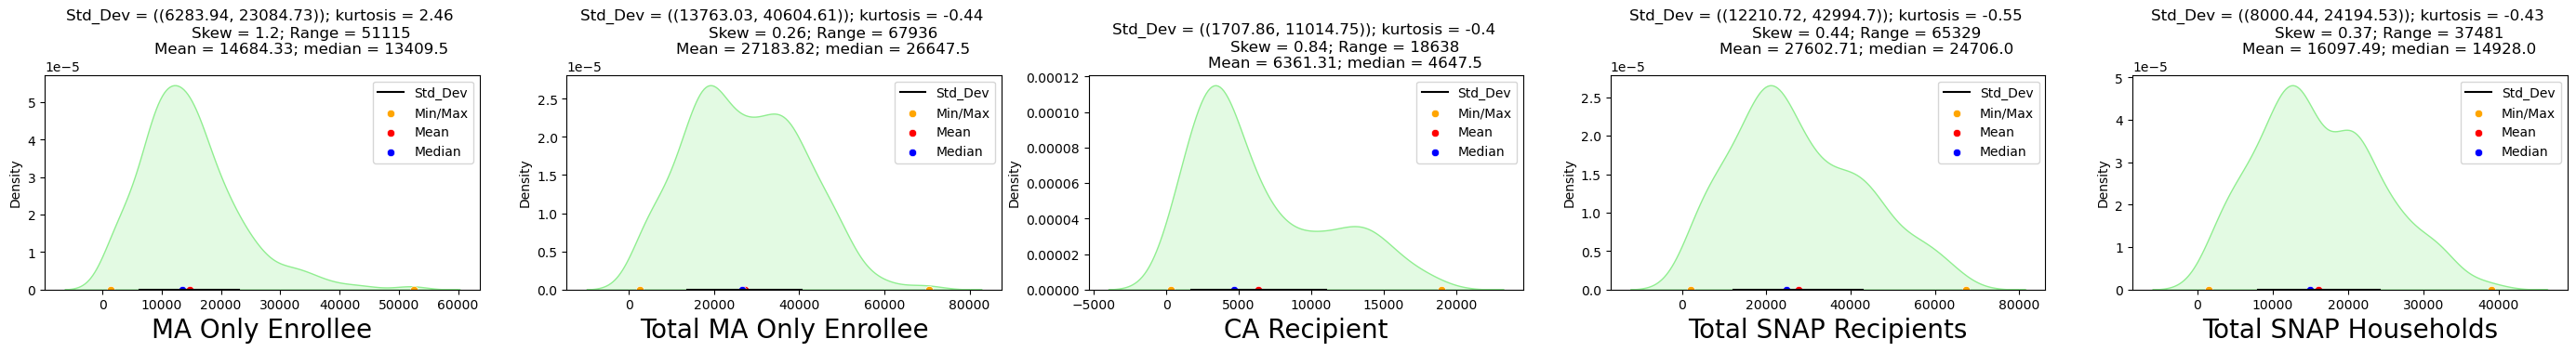

In [10]:
def UVA_Numeric(data, columns):
    '''
        Takes a group of continuous variables and plot/print all the descriptives and properties along with KDE
    '''
    size = len(columns)
    plt.figure(figsize = (7 * size, 3), dpi = 100)
    
    for index, column in enumerate(columns):
        # Calculating descriptive statistics
        _min = data[column].min()
        _max = data[column].max()
        _range = _max - _min
        mean = data[column].mean()
        median = data[column].median()
        std_dev = data[column].std()
        skew = data[column].skew()
        kurt = data[column].kurtosis()
        
        # Calculating points of standard deviation
        points = mean - std_dev, mean + std_dev
        
        # Plotting the variable with every information
        plt.subplot(1, size, index + 1)
        sns.kdeplot(data[column], fill = True, color = "LightGreen")
        sns.lineplot(x = points, y = [0,0], color = "black", label = "Std_Dev")
        sns.scatterplot(x = [_min, _max], y = [0,0], color = "orange", label = "Min/Max")
        sns.scatterplot(x = [mean], y = [0], color = "red", label = "Mean")
        sns.scatterplot(x = [median], y = [0], color = "blue", label = "Median")
        plt.xlabel(f"{column}", fontsize = 20)
        plt.ylabel("Density")
        plt.title(f"""Std_Dev = ({round(points[0], 2), round(points[1], 2)}); kurtosis = {round(kurt, 2)} 
                Skew = {round(skew, 2)}; Range = {round(_range, 2)}
                Mean = {round(mean, 2)}; median = {round(median, 2)}""")
        
continuous_variables = ["MA Only Enrollee", "Total MA Only Enrollee", "CA Recipient", "Total SNAP Recipients", "Total SNAP Households"]
UVA_Numeric(drs_cases, continuous_variables)

### Categorical Variables

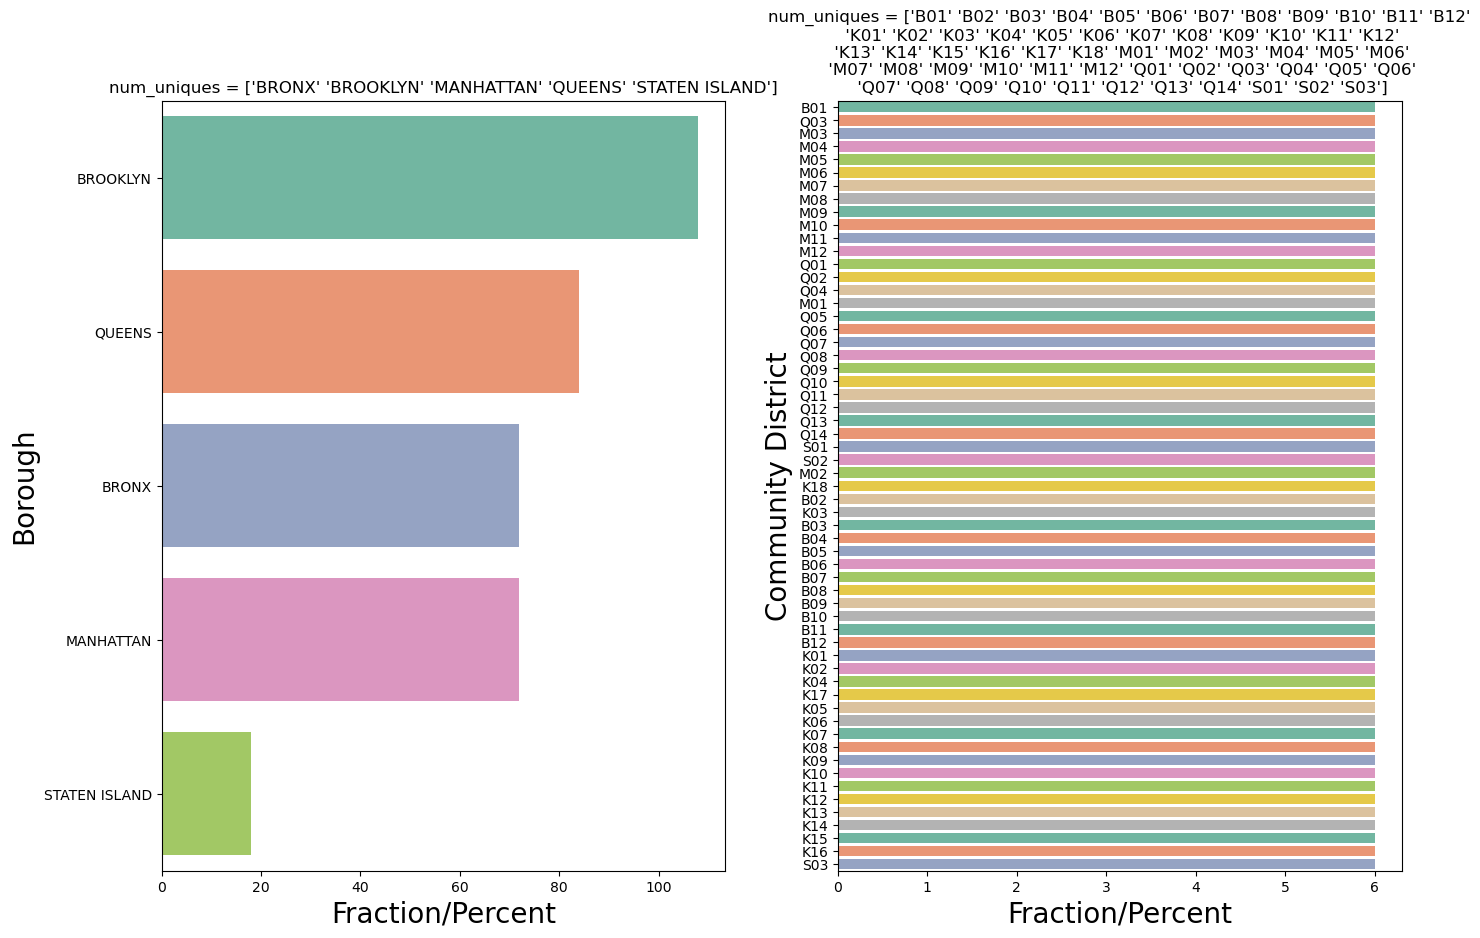

In [11]:
def UVA_Categorical(data, columns):
    '''
        Performs Univariate Analysis by taking a group of categorial variables and plots a countplot and barplot of the values
    '''
    size = len(columns)
    plt.figure(figsize = (8 * size, 10), dpi = 100)
    
    for index, column in enumerate(columns):
        # Calculating descriptive statistics
        norm_count = data[column].value_counts(normalize = True)
        num_uniques = data[column].unique()
        
        # Plotting the variable with every information
        plt.subplot(1, size, index + 1)
        sns.countplot(y = column, data = data, order = data[column].value_counts().index, palette = "Set2")
            
        plt.xlabel("Fraction/Percent", fontsize = 20)
        plt.ylabel(f"{column}", fontsize = 20)
        plt.title(f"num_uniques = {num_uniques}")

categorical_variables = ["Borough", "Community District"]
UVA_Categorical(drs_cases, categorical_variables)

## Bivariate Analysis

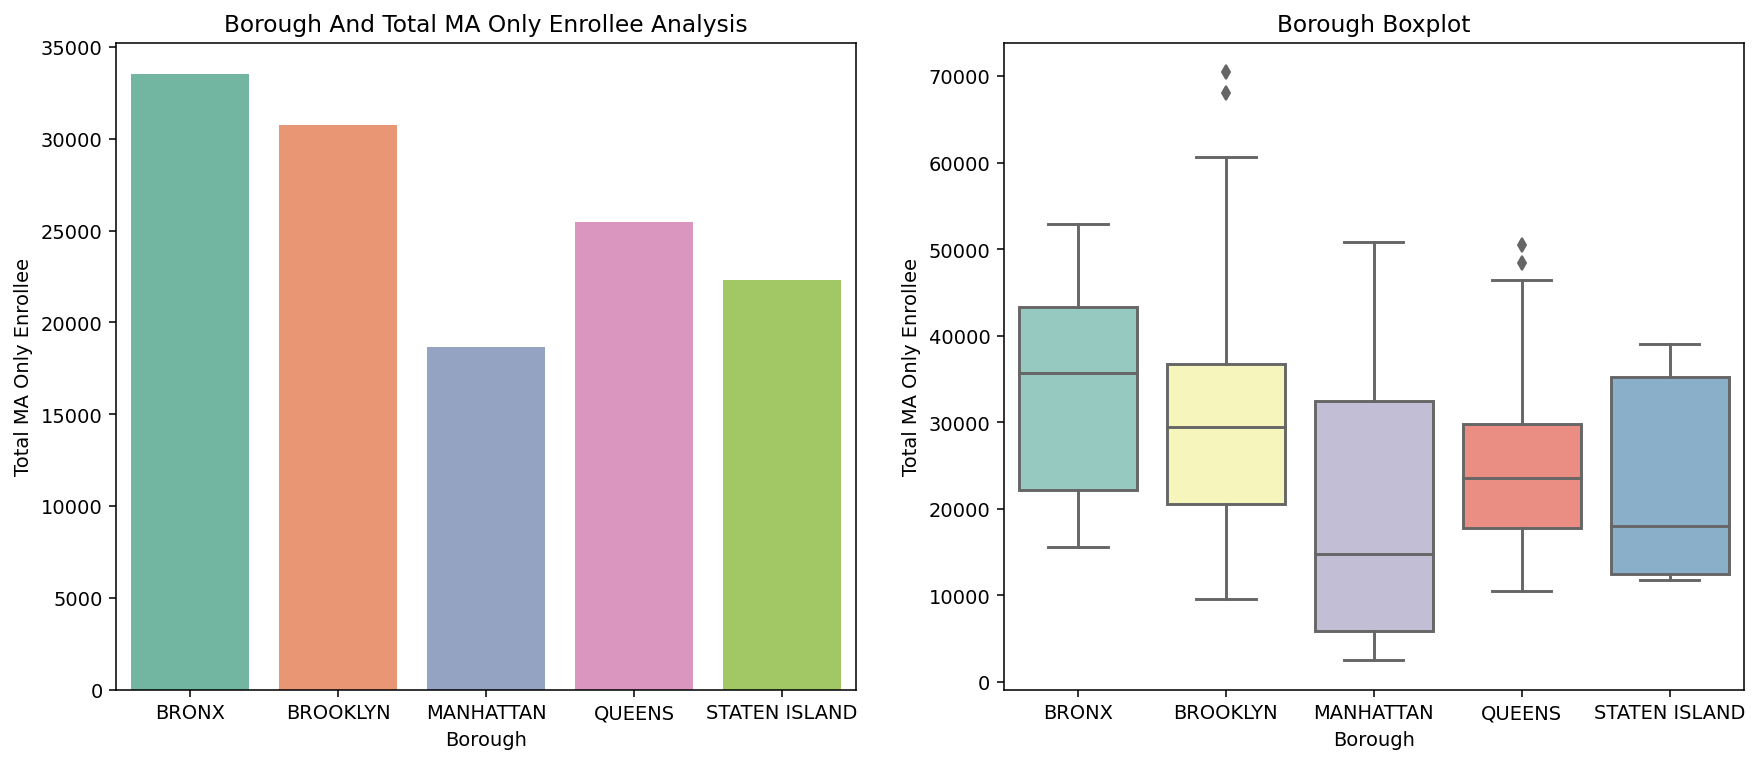

In [12]:
def biv_analysis(data, feature):
    '''
         Performs Bivariate Analysis on given data comparing the given feature, which is a categorical variable to the Total MA Only Enrollee
    '''
    pivot = data.pivot_table(index = feature, values = "Total MA Only Enrollee", aggfunc = np.mean)
    
    plt.figure(figsize = (15, 6), dpi = 140)
    
    plt.subplot(1, 2, 1)
    sns.barplot(x = feature, y = "Total MA Only Enrollee", data = data, palette = "Set2", errorbar = None)
    plt.title(f"{feature} And Total MA Only Enrollee Analysis")
    
    plt.subplot(1, 2, 2)
    sns.boxplot(x = feature, y = "Total MA Only Enrollee", data = data, palette = "Set3")
    plt.title(f"{feature} Boxplot")
    
biv_analysis(drs_cases, "Borough")

# Inference
Based on the two analyses above, the Univariant Analysis shows that Brooklyn has the most Medicaid enrollees. However, a bivariate study comparing "Borough" and "Total MA Enrollees" produces a different image, indicating that the Bronx has the greatest average number of Medicaid enrollees. However, relying solely on these two studies can be misleading, thus hypothesis testing will be used to confirm the conclusions. Because the Borough category includes numerous values, we will perform the ANOVA test to see whether there are significant differences between the boroughs. One of the disadvantages of the ANOVA test is that it will indicate that at least two levels are different but not which ones, therefore we will do a post-hoc test with Tukey's HSD to identify the means that are significantly different from each other.

          Multiple Comparison of Means - Tukey HSD, FWER=0.05           
  group1      group2      meandiff  p-adj     lower      upper    reject
------------------------------------------------------------------------
    BRONX      BROOKLYN   -2774.662 0.5795  -7933.2148  2383.8908  False
    BRONX     MANHATTAN -14889.9167    0.0 -20540.8281 -9239.0052   True
    BRONX        QUEENS  -8094.4504 0.0005 -13539.8049 -2649.0959   True
    BRONX STATEN ISLAND -11255.5972 0.0056 -20190.4727 -2320.7217   True
 BROOKLYN     MANHATTAN -12115.2546    0.0 -17273.8074 -6956.7018   True
 BROOKLYN        QUEENS  -5319.7884 0.0273 -10252.3083  -387.2685   True
 BROOKLYN STATEN ISLAND  -8480.9352 0.0568  -17112.845   150.9746  False
MANHATTAN        QUEENS   6795.4663 0.0062   1350.1117 12240.8208   True
MANHATTAN STATEN ISLAND   3634.3194 0.7984  -5300.5561  12569.195  False
   QUEENS STATEN ISLAND  -3161.1468 0.8623 -11967.4563  5645.1626  False
---------------------------------------------------

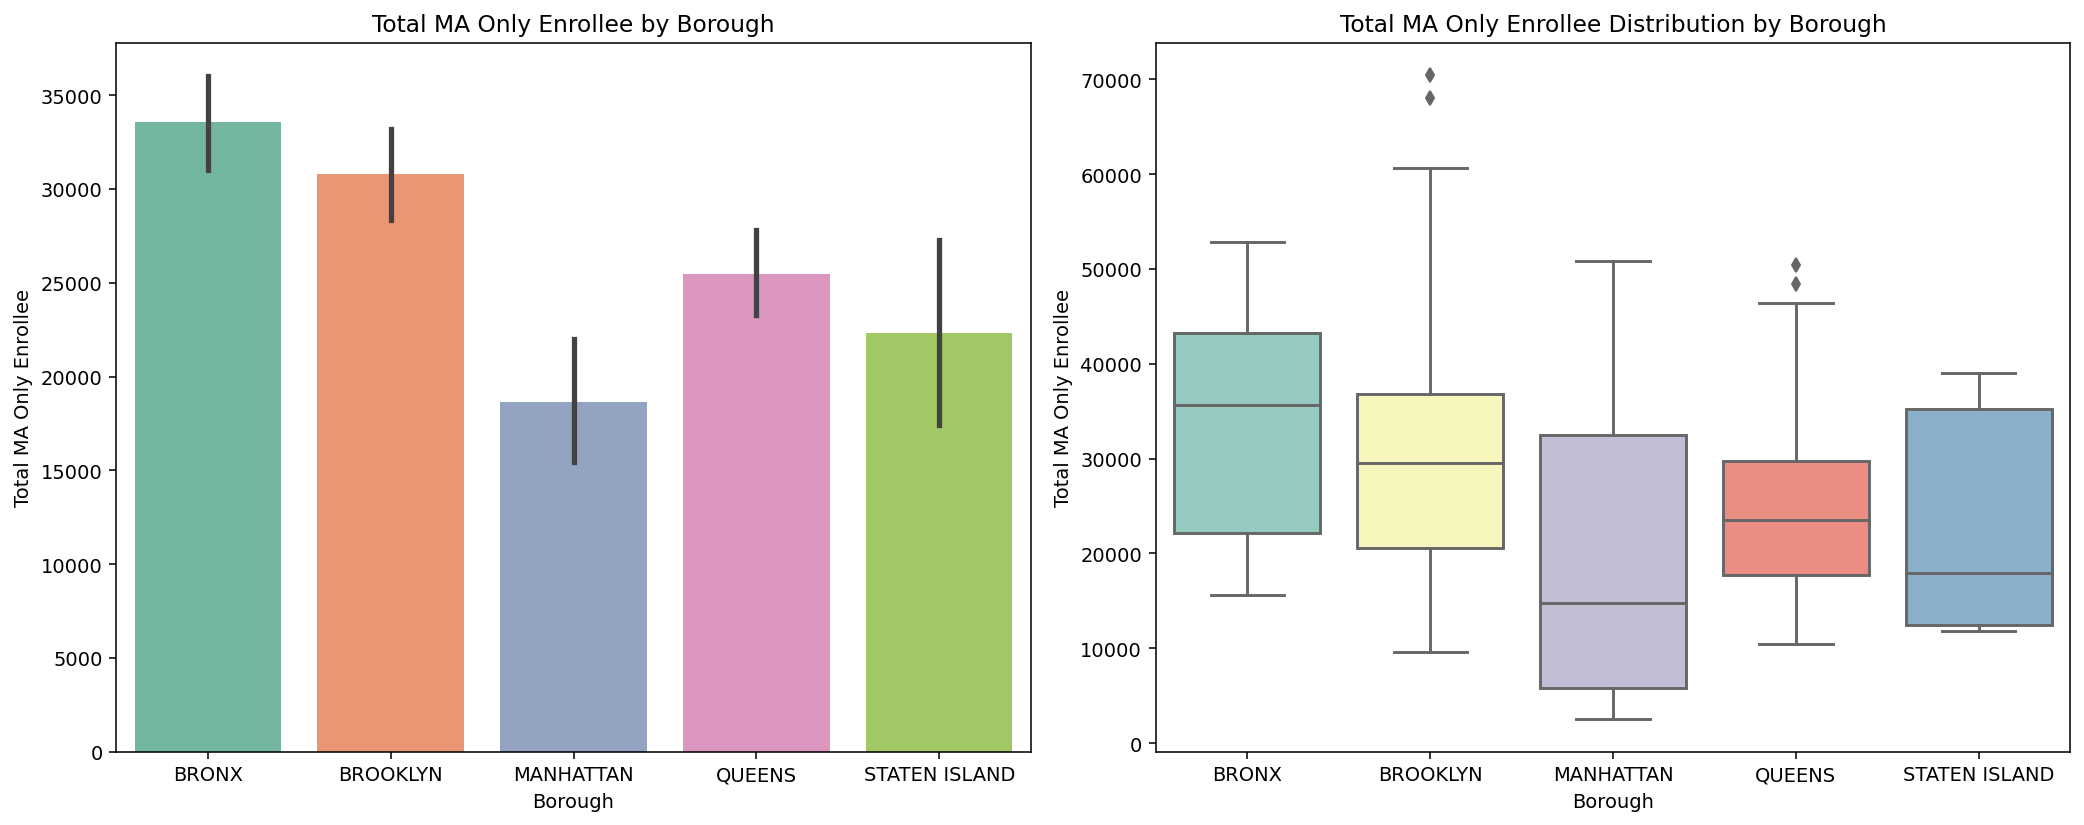

In [14]:
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Perform one-way ANOVA Test
anova_result = f_oneway(*[drs_cases[drs_cases['Borough'] == borough]['Total MA Only Enrollee'] for borough in drs_cases['Borough'].unique()])

# Perform post-hoc test (Tukey's HSD)
posthoc = pairwise_tukeyhsd(drs_cases['Total MA Only Enrollee'], drs_cases['Borough'])
print(posthoc)

# Create Matplotlib figure
plt.figure(figsize=(15, 6), dpi=140)

# First subplot - Barplot
plt.subplot(1, 2, 1)
sns.barplot(x="Borough", y="Total MA Only Enrollee", data=drs_cases, palette="Set2")
plt.xlabel("Borough")
plt.ylabel("Total MA Only Enrollee")
plt.title("Total MA Only Enrollee by Borough")

# Second subplot - Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(x="Borough", y="Total MA Only Enrollee", data=drs_cases, palette="Set3")
plt.xlabel("Borough")
plt.ylabel("Total MA Only Enrollee")
plt.title("Total MA Only Enrollee Distribution by Borough")

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

In univariant analysis, we discovered a considerable difference in the number of enrollment in the various boroughs of NYC, with Brooklyn having the greatest number. The hypothesis test yields a t-statistic value greater than the significance level (0.05) for the Bronx and Brooklyn, Brooklyn and Staten Island, Manhattan and Staten Island, and Queens and Staten Island, indicating that there are no significant differences in the average number of Medicaid enrollees within these boroughs. Significant disparities exist between the Bronx and Manhattan, Bronx and Staten Island, Bronx and Queens, Brooklyn and Manhattan, Brooklyn and Queens, and Manhattan and Queens, as evidenced by t-statistics values smaller than the significance level.

# Conclusion
The examination of Medicaid participants throughout New York City's boroughs yields complex results. Initially, univariate analysis indicates that Brooklyn has the largest total enrollment. However, a more thorough evaluation using a bivariate analysis reveals that the Bronx has the greatest average enrollment. To validate these findings, hypothesis testing was used, with ANOVA to detect overall differences between boroughs and Tukey's HSD for particular comparisons. The results show that while some boroughs have equal average enrollments, others have large variances. Specifically, the Bronx routinely shows substantial variances when compared to other boroughs, showing a higher average Medicaid enrollment rate. These findings highlight the necessity of thorough analysis tools to reliably discover patterns in complicated datasets, allowing for informed decision-making.